In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import psycopg2
from postgis.psycopg import register
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon
from shapely.geometry import box
import project_path
from db_importer.settings import *
import scipy.stats
from scipy.stats import ks_2samp


class DatabaseConnection(object):
    def __enter__(self):
        self.conn = psycopg2.connect(f"dbname='{DB_NAME}' user='{DB_USER}' password='{DB_PASSWORD}' host='{DB_HOST}' port='{DB_PORT}'")
        self.conn.autocommit = True

        register(self.conn)
        self.cur = self.conn.cursor()

        return self.cur

    def __exit__(self, exc_type, exc_val, exc_tb):
        if exc_tb is None:
            self.conn.commit()
            self.cur.close()
            self.conn.close()
        else:
            self.conn.rollback()
            self.cur.close()
            self.conn.close()

In [2]:
start_rect = box(13.4155, 52.5213, 13.4167, 52.5219)
end_rect = box(13.4149, 52.5223, 13.4159, 52.5229)

def get_SUMO_durations(x):
    
    mask_first = x.apply(lambda coord: start_rect.contains(Point(coord['vehicle_x'], coord['vehicle_y'])), axis=1)
    mask_end = x.apply(lambda coord: end_rect.contains(Point(coord['vehicle_x'], coord['vehicle_y'])), axis=1)
    vehicle_id = x.iloc[0].vehicle_id
    try:
        start = x[mask_first==True].iloc[0].timestep_time
        end = x[mask_end==True].iloc[0].timestep_time
        return (vehicle_id, end - start)
    except: 
        return None, None
    

In [3]:
files= ['../sim_data/alex_default.csv', '../sim_data/alex_im.csv']

durations_arr = []

for file in files:
    df = pd.read_csv(file, delimiter=';')
    print(len(df))
    df = df[df.vehicle_id.str.startswith('flow_2', na=False)]
    
    grouped = df.groupby('vehicle_id')
    durations = grouped.apply(lambda x: get_SUMO_durations(x)[1]).dropna()
    durations_arr.append(durations.values)
    


14758
12711


In [4]:
from statsmodels.distributions.empirical_distribution import ECDF

with DatabaseConnection() as cur:
    cur.execute("""SELECT
            filename,
            ST_AsGeoJSON(geom_raw) :: json->'coordinates' AS coordinates,
            timestamps,
            velos
        FROM ride
        WHERE st_intersects(geom,
            st_setsrid(st_makebox2d(st_makepoint(13.4155, 52.5213), st_makepoint(13.4167, 52.5219)), 4326))
          AND st_intersects(geom, 
            st_setsrid(st_makebox2d(st_makepoint(13.4149, 52.5223), st_makepoint(13.4159, 52.5229)), 4326))
          """)
    res = cur.fetchall()
    df = pd.DataFrame(res, columns=['filename', 'coords', 'timestamps', 'velo'])
    print(len(df))

def get_ride_durations(arr):
    coords = np.array(arr[0])
    timestamps = np.array(arr[1])
    first = None
    last = None
    for i, coord in enumerate(coords):
        point = Point(coord[0],coord[1])
        if (first is None) & start_rect.contains(point):
            first = i
            continue
        if (first is not None) & end_rect.contains(point):
            last = i
            break
    try:
        res = (timestamps[last] - timestamps[first]).total_seconds()
        if res > 150: # outlier
            return None
    except:
        res = None
    return res

test = df.apply(lambda x: get_ride_durations(x[['coords', 'timestamps']].to_numpy()), axis=1)
simra_durations = test[~test.isnull()].values

print(ks_2samp(durations_arr[0], simra_durations))
print(ks_2samp(durations_arr[1], simra_durations))


1103
KstestResult(statistic=0.1723585548738923, pvalue=0.0006810843971651881)
KstestResult(statistic=0.29275522161715034, pvalue=3.318877260904962e-06)


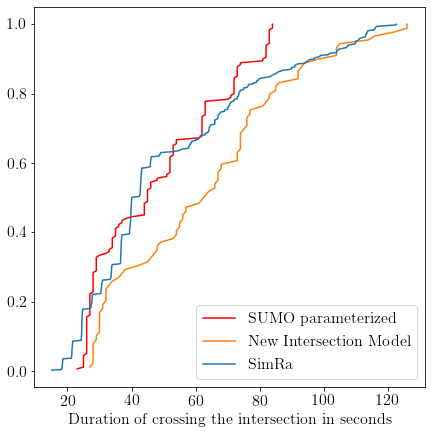

In [7]:
from statsmodels.distributions.empirical_distribution import ECDF
from matplotlib import rc

colors = [u'#1f77b4', u'#ff7f0e', u'#2ca02c']

plt.figure(figsize=(7,7))
rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'size': 16})
rc('text', usetex=True)
#plt.title('Empirical Cumulative Distribution Function')
plt.xlabel('Duration of crossing the intersection in seconds')
ecdf = ECDF(durations_arr[0])
plt.plot(ecdf.x, ecdf.y, c='r', label='SUMO parameterized')
ecdf = ECDF(durations_arr[1])
plt.plot(ecdf.x, ecdf.y, c=colors[1], label='New Intersection Model')
ecdf = ECDF(simra_durations)
plt.plot(ecdf.x, ecdf.y, c=colors[0], label='SimRa')
plt.legend()
plt.savefig('images/im_alex_edcf.png', dpi=300, bbox_inches='tight')